<a href="https://colab.research.google.com/github/y-oth/dst_assessment2/blob/main/Elliot%20M/IntegratedGradientsImplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


TO DO THIS, GO ON KAGGLE :https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri

THEN DOWLOAD TO ZIP USINNG THE DOWLOAD BUTTON.

THEN ADD IT TO YOUR GOOGLE DRIVE AS A ZIP FILE.
THEN MYDIRVE/YOUR_NOTEBOOK/DATASET.ZIP


In [2]:
!unzip "/content/drive/MyDrive/DST/archive.zip" -d "/content/data"



Archive:  /content/drive/MyDrive/DST/archive.zip
  inflating: /content/data/Testing/glioma_tumor/image(1).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(10).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(100).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(11).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(12).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(13).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(14).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(15).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(16).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(17).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(18).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(19).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(2).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(20).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(21

In [3]:
!ls /content/data


Testing  Training


Loaded image: /content/data/Training/glioma_tumor/gg (217).jpg


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

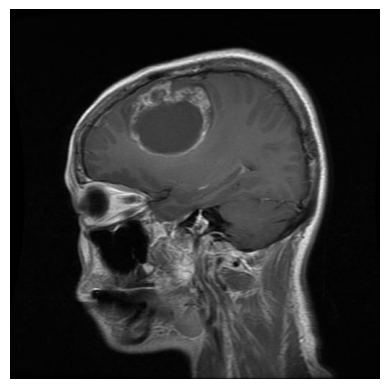

In [4]:
import os
from PIL import Image
import matplotlib.pyplot as plt

root = "/content/data/Training"

# Find the first image in the training folder
image_path = None
for subdir, dirs, files in os.walk(root):
    for file in files:
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            image_path = os.path.join(subdir, file)
            break
    if image_path:
        break

print("Loaded image:", image_path)

img = Image.open(image_path)
plt.imshow(img)
plt.axis("off")


## Simple CNN Model

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SmallCNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)

        # 224 → 112 → 56 after pooling twice
        self.fc1 = nn.Linear(32 * 56 * 56, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # (16, 112, 112)
        x = self.pool(F.relu(self.conv2(x)))   # (32, 56, 56)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


## Multi-Layer Perceptron:

Here, we also build a simple multi-layer perceptron which will likely perform badly, and using our interpretation method heatmaps, we can show that the MLP does not encapture the 2D structure of the input (image) and therefore performs much worse.

In [7]:
class BrainTumourMLP(nn.Module):
    def __init__(self, input_dim=3*224*224, hidden1=512, hidden2=256, num_classes=4):
        super().__init__()

        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(hidden2, num_classes)
        )

    def forward(self, x):
        return self.model(x)


## Dataloaders

These will stay the same for the CNN and MLP as the MLP flattens the image as the first step using nn.Flatten().

In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

train_dataset = datasets.ImageFolder("/content/data/Training", transform=transform)
test_dataset  = datasets.ImageFolder("/content/data/Testing",  transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


## CNN Training block

In [9]:
import torch.optim as optim
import os, time, json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallCNN(num_classes=4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

best_val_acc = 0
checkpoint_path = "best_smallcnn.pth"

history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

EPOCHS = 10   # fast training

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # ------- VALIDATION -------
    model.eval()
    val_running_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / len(test_loader)
    val_acc = val_correct / val_total

    # Track
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] | "
          f"Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f}")

    # Save based on accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Saved best model → {checkpoint_path}")


Epoch [1/10] | Train Acc: 0.619 | Val Acc: 0.513
Saved best model → best_smallcnn.pth
Epoch [2/10] | Train Acc: 0.840 | Val Acc: 0.647
Saved best model → best_smallcnn.pth
Epoch [3/10] | Train Acc: 0.929 | Val Acc: 0.718
Saved best model → best_smallcnn.pth
Epoch [4/10] | Train Acc: 0.964 | Val Acc: 0.734
Saved best model → best_smallcnn.pth
Epoch [5/10] | Train Acc: 0.990 | Val Acc: 0.766
Saved best model → best_smallcnn.pth
Epoch [6/10] | Train Acc: 0.998 | Val Acc: 0.728
Epoch [7/10] | Train Acc: 1.000 | Val Acc: 0.734
Epoch [8/10] | Train Acc: 1.000 | Val Acc: 0.739
Epoch [9/10] | Train Acc: 1.000 | Val Acc: 0.739
Epoch [10/10] | Train Acc: 1.000 | Val Acc: 0.739


In [10]:
model = SmallCNN(num_classes=4)
model.load_state_dict(torch.load("best_smallcnn.pth"))
model.to(device)
model.eval()


SmallCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=4, bias=True)
)

## MLP Training Block

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp = BrainTumourMLP(num_classes=4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)


for epoch in range(10):
    mlp.train()
    running_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = mlp(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss = {running_loss/len(train_loader):.4f}")


Epoch 1, Loss = 10.2696
Epoch 2, Loss = 1.1812
Epoch 3, Loss = 1.2793
Epoch 4, Loss = 1.3852
Epoch 5, Loss = 1.2775
Epoch 6, Loss = 1.3620
Epoch 7, Loss = 1.3076
Epoch 8, Loss = 1.2886
Epoch 9, Loss = 1.2667
Epoch 10, Loss = 1.2446


In [12]:
mlp.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = mlp(images)
        _, predicted = outputs.max(1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"MLP Test Accuracy: {correct/total:.4f}")


MLP Test Accuracy: 0.4137


As we would expect, the MLP gets a low test accuracy. Now we will implement our interpretation methods and show that the CNN highlights meaning regions (tumour outlines) and the MLP does not.

## Integrated Gradients Implementation

In [13]:

def integrated_gradients(model, x, baseline=None, m_steps=50):
    """
    Compute Integrated Gradients for an input x.
    model: pytorch model
    x: input image tensor of shape (1, C, H, W)
    baseline: same shape as x
    m_steps: number of steps in the Riemann approximation
    """

    model.eval()
    if baseline is None:
        baseline = torch.zeros_like(x)

    # interpolate between baseline and x
    alphas = torch.linspace(0, 1, m_steps).reshape(-1, 1, 1, 1).to(x.device)
    interpolated = baseline + alphas * (x - baseline)

    # store gradients
    gradients = []

    for i in range(m_steps):
        interpolated_i = interpolated[i].unsqueeze(0).requires_grad_(True)
        output = model(interpolated_i)
        target = output.max(1)[0]  # predicted class score

        model.zero_grad()
        target.backward()

        gradients.append(interpolated_i.grad.detach())

    # approximate integral
    avg_gradients = torch.mean(torch.stack(gradients), dim=0)

    # IG formula
    ig = (x - baseline) * avg_gradients
    return ig


## SG-IG Implementation

In [14]:

def smooth_integrated_gradients(
    model, x, baseline=None, m_steps=50, n_samples=25, noise_sigma=0.1
):
    """
    Compute Smooth Integrated Gradients.
    Averaging IG over noise-perturbed copies of input x.
    """

    model.eval()
    if baseline is None:
        baseline = torch.zeros_like(x)

    all_igs = []

    for _ in range(n_samples):
        noise = torch.normal(mean=0, std=noise_sigma, size=x.shape).to(x.device)
        x_noisy = x + noise
        ig = integrated_gradients(model, x_noisy, baseline, m_steps)
        all_igs.append(ig)

    return torch.mean(torch.stack(all_igs), dim=0)


Let's get an explainer image and then apply the two interpretation methods, for both the CNN and MLP. First we need to denormalize the explainer image in order to get meaningful plots.

In [16]:
explainer_image, explainer_label = next(iter(test_loader))
explainer_image = explainer_image[2]        # take first image in batch
explainer_label = explainer_label[2].item()

explainer_image_device = explainer_image.unsqueeze(0).to(device)

def denormalize(x, mean, std):
    mean = torch.tensor(mean).view(1, 3, 1, 1).to(x.device)
    std = torch.tensor(std).view(1, 3, 1, 1).to(x.device)
    return x * std + mean


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

explainer_image_denorm = denormalize(explainer_image_device, mean, std)
baseline = torch.zeros_like(explainer_image_denorm)

# CNN
cnn_ig = integrated_gradients(
    model=model,
    x=explainer_image_denorm,
    baseline=baseline,
    m_steps=50
)

cnn_sg_ig = smooth_integrated_gradients(
    model=model,
    x=explainer_image_denorm,
    baseline=baseline,
    m_steps=50,
    n_samples=20,
    noise_sigma=0.1
)

# MLP

mlp_ig = integrated_gradients(
    model=mlp,
    x=explainer_image_denorm,
    baseline=baseline,
    m_steps=50
)

mlp_sg_ig = smooth_integrated_gradients(
    model=mlp,
    x=explainer_image_denorm,
    baseline=baseline,
    m_steps=50,
    n_samples=20,
    noise_sigma=0.1
)



## Heatmap plots

Now we can plot IG and SG-IG for both the MLP and CNN

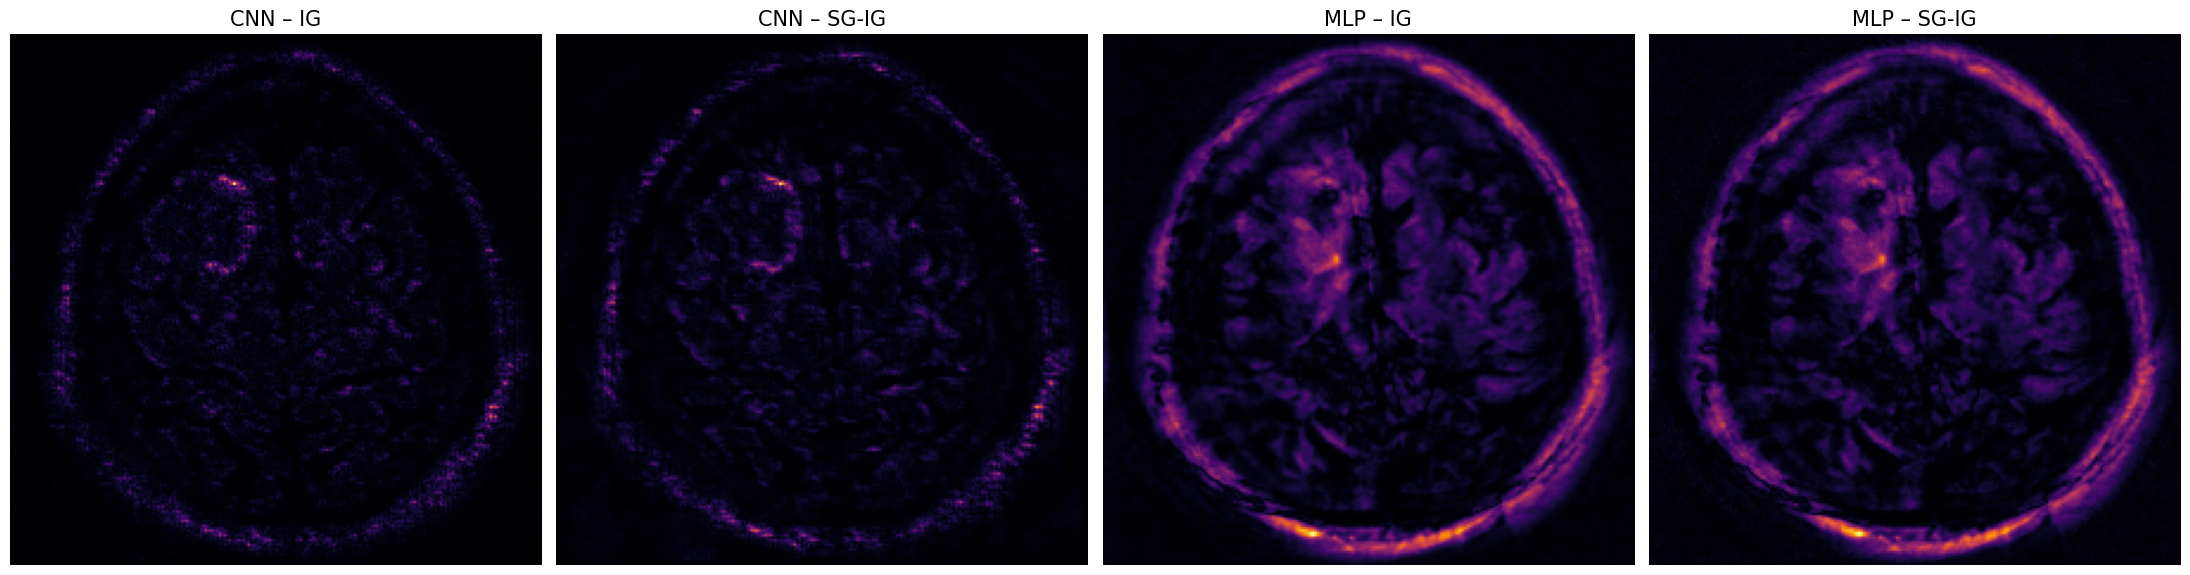

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def to_heatmap(attr):
    # sum over channel dimension
    attr = attr.squeeze(0).detach().cpu().numpy()
    attr = np.abs(attr).mean(axis=0)  # (H, W)
    return attr

fig, axes = plt.subplots(1, 4, figsize=(22, 6))

heatmaps = [
    ("CNN – IG", to_heatmap(cnn_ig)),
    ("CNN – SG-IG", to_heatmap(cnn_sg_ig)),
    ("MLP – IG", to_heatmap(mlp_ig)),
    ("MLP – SG-IG", to_heatmap(mlp_sg_ig)),
]

for ax, (title, hm) in zip(axes, heatmaps):
    ax.imshow(hm, cmap='inferno')
    ax.set_title(title, fontsize=15)
    ax.axis("off")

plt.tight_layout()
plt.show()


These plots are very telling; we can see that the interpretability methods for the CNN only highlight the outline of the tumour, with the brightest pixel being exactly on the edge of the tumour. Conversely, the MLP seems to highlight thet entire outline of the skull, but does impressively manage to highlight the tumour. Let's have a look at more plots to check the consistency of this.

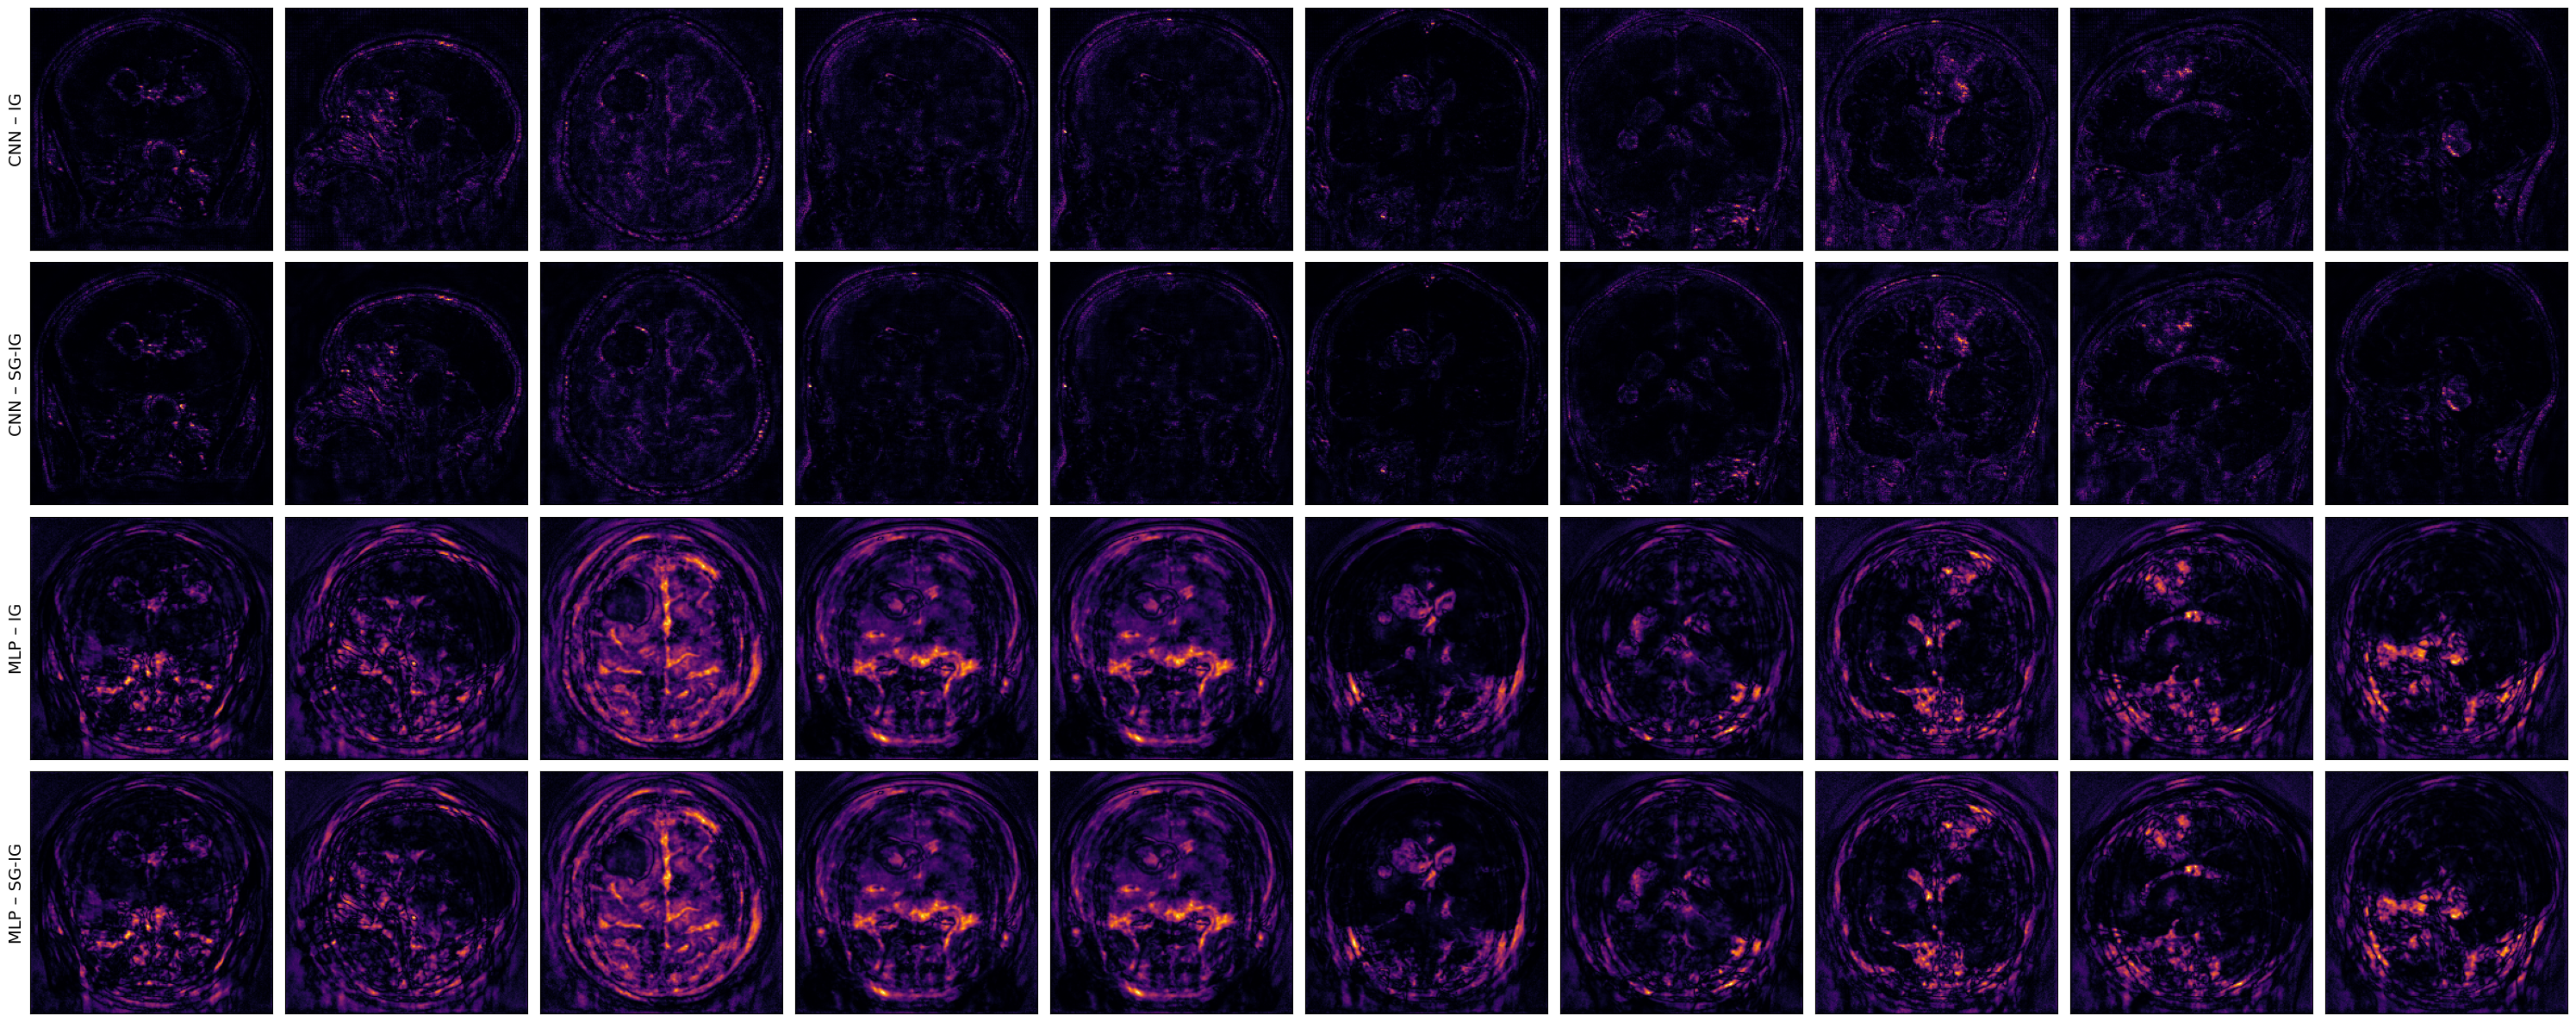

In [20]:
def compare_models_over_images(cnn, mlp, images, n=10):
    """
    cnn: trained CNN model
    mlp: trained MLP model
    images: list or tensor of images (each shape (1,3,H,W))
    n: number of images to process
    """

    n = min(n, len(images))

    fig, axes = plt.subplots(4, n, figsize=(3*n, 12))

    for idx in range(n):
        x = images[idx].to(device)

        # ----- Compute attributions -----
        cnn_ig    = integrated_gradients(cnn, x)
        cnn_sg    = smooth_integrated_gradients(cnn, x)

        mlp_ig    = integrated_gradients(mlp, x)
        mlp_sg    = smooth_integrated_gradients(mlp, x)

        # ----- Convert to heatmaps -----
        maps = [
            to_heatmap(cnn_ig),
            to_heatmap(cnn_sg),
            to_heatmap(mlp_ig),
            to_heatmap(mlp_sg)
        ]

        # ----- Plot in the 4×N grid -----
        titles = [
            "CNN – IG",
            "CNN – SG-IG",
            "MLP – IG",
            "MLP – SG-IG",
        ]

        for row in range(4):
            ax = axes[row, idx] if n > 1 else axes[row]
            ax.imshow(maps[row], cmap='inferno')
            if idx == 0:  # only annotate first column
                ax.set_ylabel(titles[row], fontsize=14)
            ax.set_xticks([])
            ax.set_yticks([])

    plt.tight_layout()
    plt.show()


# Let's get 10 images from the test loader
sample_images = []

for imgs, labels in test_loader:          # imgs: (B, 3, H, W)
    for j in range(imgs.size(0)):        # loop over batch dimension
        sample_images.append(imgs[j:j+1])  # keep shape (1, 3, H, W)
        if len(sample_images) == 10:
            break
    if len(sample_images) == 10:
        break


compare_models_over_images(model, mlp, sample_images, n=10)
